In [102]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
from collections import Counter
from data_science_toolkit.data_visualization import get_fig_ax, visualize_class_distribution, top_n_tokens_plot_from_counter
import matplotlib.pyplot as plt
import nltk
import  re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
# Stealing stuff... http://brandonrose.org/clustering
from nltk.stem.snowball import SnowballStemmer
import nltk, re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import *
from datetime import date

In [103]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [104]:
stock_tweet = pd.read_csv('./since_election_with_cluster_trump_tweets_sp500.csv')
stock_tweet['created_at']= pd.to_datetime(stock_tweet['created_at']) 
stock_tweet['dow'] = stock_tweet.dow.astype('category')
stock_tweet['num_links'] = stock_tweet.num_links.astype('category')
stock_tweet['num_words'] = stock_tweet.num_words.astype('category')
stock_tweet['cluster_number'] = stock_tweet.cluster_number.astype('category')
stock_tweet['created_hour'] = stock_tweet.created_hour.astype('category')

In [105]:
stock_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4395 entries, 0 to 4394
Data columns (total 21 columns):
text                 4395 non-null object
created_at           4395 non-null datetime64[ns]
retweet_count        4395 non-null float64
favorite_count       4395 non-null int64
is_retweet           4395 non-null bool
after_dir            4395 non-null int64
1_open_dir           4395 non-null int64
1_close_dir          4395 non-null int64
2_open_dir           4395 non-null int64
2_close_dir          4395 non-null int64
eow_close_dir        4395 non-null int64
sow_open_dir         4395 non-null int64
sig_up               4395 non-null int64
sig_down             4395 non-null int64
is_sig               4395 non-null int64
preprocessed_text    4395 non-null object
created_hour         4395 non-null category
dow                  4395 non-null category
num_links            4395 non-null category
num_words            4395 non-null category
cluster_number       4395 non-null category
dtype

In [106]:
stop_words = set(stopwords.words('english')).union({''})
print(stop_words)

{'', 'until', 'couldn', "that'll", 'an', 'didn', "isn't", 'himself', 'after', "wouldn't", 'up', 'nor', 'yourselves', 'his', 'be', 'has', 'it', 'only', 'their', 'd', 'below', "it's", "should've", "you've", 'any', 's', "haven't", 'too', 'her', 'hasn', 'having', 'other', 'through', 'mustn', "mustn't", 'whom', 'when', 'wasn', 'haven', 're', 't', 'have', "you'll", 'both', "shouldn't", 'no', 'll', 'yourself', 'a', 'while', 'yours', 'o', 'few', 'were', 'into', 'off', 'down', 'here', 'y', 'the', 'he', 'now', 'above', 'aren', 'these', 'such', 'by', 'as', 'how', 'for', 'so', "wasn't", 'me', 'my', 'and', 'that', 'same', 'theirs', 'doing', 'each', 'again', 'm', 'our', "don't", 'before', 'most', 'than', 'all', 'or', 'over', "weren't", "you'd", "won't", 'where', 'did', 'we', "she's", 'won', 'about', 'those', 'hadn', 'some', 'will', "needn't", 'been', 'who', 'this', 'should', 'between', 'is', 'with', 'under', 'itself', 'very', 'themselves', 'doesn', 'weren', 'once', 'what', "hadn't", 'being', "you're

In [107]:
len(stock_tweet.index)

4395

In [108]:
# from data_science_toolkit.dataset_ops import classifier_train_test_split
# train_in, test_in, train_out, test_out = classifier_train_test_split(stock_tweet.preprocessed_text.tolist(), stock_tweet.after_dir.tolist(), test_size=0.2, random_state=1)
from data_science_toolkit.dataset_ops import classifier_train_val_test_dfs
# Need to shuffle!!
train_df, val_df, test_df = classifier_train_val_test_dfs(stock_tweet.sample(frac=1), "after_dir", train_val_test_split=(0.8,0.1,0.1), random_state=1)

4395it [00:00, 950890.65it/s]
3955it [00:00, 1153419.02it/s]


In [109]:
train_in = train_df['preprocessed_text'].tolist()
train_out = train_df['after_dir'].tolist()
val_in = val_df['preprocessed_text'].tolist()
val_out = val_df['after_dir'].tolist()
test_in = test_df['preprocessed_text'].tolist()
test_out = test_df['after_dir'].tolist()

# STOLE A BUNCH OF SHIT FROM HERE: https://medium.com/@chrisfotache/text-classification-in-python-pipelines-nlp-nltk-tf-idf-xgboost-and-more-b83451a327e0

In [9]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
#     tokens = text.split(" ")
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
#     stems = [stemmer.stem(t) for t in text.split(" ")]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

def already_preprocessed_tokenize(text):
    tokens = text.split(" ")
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [10]:
stemmer = SnowballStemmer("english")

In [11]:
preprocessed_vocab = ' '.join(stock_tweet['preprocessed_text'].tolist())
total_vocab = list(set(tokenize_only(preprocessed_vocab)))
total_vocab_stemmed = [stemmer.stem(t) for t in total_vocab]
vocab_frame = pd.DataFrame({'words': total_vocab}, index = total_vocab_stemmed)
print('there are ', str(vocab_frame.shape[0]), ' items in vocab_frame')

there are  9588  items in vocab_frame


In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#define vectorizer parameters
# tfidf_vectorizer = TfidfVectorizer(max_df=0.9,
#                                  min_df=1, stop_words=stop_words,
#                                  use_idf=True, tokenizer=already_preprocessed_tokenize, ngram_range=(1,3))
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,
                                 min_df=1,
                                 use_idf=True, tokenizer=already_preprocessed_tokenize, ngram_range=(1,4))
# svd = TruncatedSVD(n_components=2000)
# pipeline = Pipeline([
#     ('tfidf', tfidf_vectorizer),
#     ('svd', svd)])

# train_x = pipeline.fit_transform(train_in)
train_x = tfidf_vectorizer.fit_transform(train_in) #fit the vectorizer to synopses
test_x = tfidf_vectorizer.transform(test_in)
# test_x = pipeline.transform(test_in)

In [13]:
# get_numeric_data = FunctionTransformer(lambda x: x[['num1','num2']], validate=False)
# process_and_join_features = Pipeline([
#     ('features', FeatureUnion([
#             ('numeric_features', Pipeline([
#                 ('selector', get_numeric_data)
#             ])),
#              ('text_features', Pipeline([
#                 ('selector', get_text_data),
#                 ('vec', CountVectorizer())
#             ]))
#          ])),
#     ('clf', OneVsRestClassifier(LogisticRegression()))
# ])

from sklearn.base import BaseEstimator, TransformerMixin

# class AverageWordLengthExtractor(BaseEstimator, TransformerMixin):
#     """Takes in dataframe, extracts road name column, outputs average word length"""

#     def __init__(self):
#         pass

#     def average_word_length(self, name):
#         """Helper code to compute average word length of a name"""
#         return np.mean([len(word) for word in name.split()])

#     def transform(self, df, y=None):
#         """The workhorse of this feature extractor"""
#         return df['road_name'].apply(self.average_word_length)

#     def fit(self, df, y=None):
#         """Returns `self` unless something different happens in train and test"""
#         return self
# class NumericalExtractor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
#     def fit(self, df, y=None):
#         return df
#     def transform(self, df, y=None):
#         return df

# class TFIDFVectorizerExtractor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.vec = None
#     def fit(self, df, y=None):
#         self.vec = TfidfVectorizer(max_df=0.9,
#                                  min_df=1,
#                                  use_idf=True, tokenizer=already_preprocessed_tokenize, ngram_range=(1,4))
#         return self.vec.fit(df['preprocessed_text'].tolist())
#     def transform(self, df, y=None):
#         return self.vec.transform(df['preprocessed_text'].tolist())
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.field]]

In [79]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# pipeline = Pipeline([
#     ('feats', FeatureUnion([
#         ('ngram', TFIDFVectorizerExtractor('preprocessed_text')), # can pass in either a pipeline
#         ('ave', NumericalExtractor('dow')) # or a transformer
#     ])),
#     ('clf', SVC(probability=True, gamma='scale', kernel='rbf'))  # classifier
# ])
# , 'cluster_number', 'created_hour'
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('preprocessed_text')),
            ('tfidf', TfidfVectorizer(max_df=0.9,min_df=1,use_idf=True, tokenizer=already_preprocessed_tokenize, ngram_range=(1,4)))
        ])),
        ('dow', Pipeline([
            ('dowext', NumberSelector('dow')),
            ('dowscaler', StandardScaler()),
        ])),
        ('cluster_number', Pipeline([
            ('clusterext', NumberSelector('cluster_number')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('created_hour', Pipeline([
            ('createdext', NumberSelector('created_hour')),
            ('createdscaler', StandardScaler()),
        ])),
    ])),
    ('clf', SVC(probability=True, gamma='scale', kernel='rbf')),
    ])

In [80]:
classifier.fit(train_df, train_out)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text',
                                                 Pipeline(memory=None,
                                                          steps=[('colext',
                                                                  TextSelector(field='preprocessed_text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
      

In [115]:
train_df_random_forest = None
train_df_random_forest = pd.concat([train_df, pd.get_dummies(train_df[['dow', 'num_links', 'num_words', 'created_hour', 'cluster_number']])], axis=1)
# train_df_random_forest = train_df.join()

In [116]:
train_df_random_forest.columns.tolist()
# pd.get_dummies(train_df[['dow', 'num_links', 'num_words', 'created_hour']])

['text',
 'created_at',
 'retweet_count',
 'favorite_count',
 'is_retweet',
 'after_dir',
 '1_open_dir',
 '1_close_dir',
 '2_open_dir',
 '2_close_dir',
 'eow_close_dir',
 'sow_open_dir',
 'sig_up',
 'sig_down',
 'is_sig',
 'preprocessed_text',
 'created_hour',
 'dow',
 'num_links',
 'num_words',
 'cluster_number',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6',
 'num_links_0',
 'num_links_1',
 'num_words_6',
 'num_words_7',
 'num_words_8',
 'num_words_9',
 'num_words_10',
 'num_words_11',
 'num_words_12',
 'num_words_13',
 'num_words_14',
 'num_words_15',
 'num_words_16',
 'num_words_17',
 'num_words_18',
 'num_words_19',
 'num_words_20',
 'num_words_21',
 'num_words_22',
 'num_words_23',
 'num_words_24',
 'num_words_25',
 'num_words_26',
 'num_words_27',
 'num_words_28',
 'num_words_29',
 'num_words_30',
 'num_words_31',
 'num_words_32',
 'num_words_33',
 'num_words_34',
 'num_words_35',
 'num_words_36',
 'num_words_37',
 'num_words_38',
 'num_words_39',
 'num_wo

In [114]:
train_df_random_forest.head(1)

,text,created_at,retweet_count,favorite_count,is_retweet,after_dir,1_open_dir,1_close_dir,2_open_dir,2_close_dir,...,created_hour_14,created_hour_15,created_hour_16,created_hour_17,created_hour_18,created_hour_19,created_hour_20,created_hour_21,created_hour_22,created_hour_23
314,Happy Canada Day to all of the great people of Canada and to your Prime Minister and my new found friend @JustinTrudeau. #Canada150,2017-07-01 12:44:23,16360.0,78780,False,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
classifier2 = Pipeline([
    ('features', FeatureUnion([
        ('bow', Pipeline([
            ('colext', TextSelector('preprocessed_text')),
            ('counts', CountVectorizer(stop_words=stop_words, ngram_range=(1,5)))
        ])),
        ('text', Pipeline([
            ('colext', TextSelector('preprocessed_text')),
            ('tfidf', TfidfVectorizer(max_df=0.9,min_df=1,use_idf=True, tokenizer=already_preprocessed_tokenize, ngram_range=(1,4)))
        ])),
        ('dow_0', Pipeline([
            ('dowext', NumberSelector('dow_0')),
            ('dowscaler', StandardScaler()),
        ])),
        ('dow_1', Pipeline([
            ('dowext', NumberSelector('dow_1')),
            ('dowscaler', StandardScaler()),
        ])),
        ('dow_2', Pipeline([
            ('dowext', NumberSelector('dow_2')),
            ('dowscaler', StandardScaler()),
        ])),
        ('dow_3', Pipeline([
            ('dowext', NumberSelector('dow_3')),
            ('dowscaler', StandardScaler()),
        ])),
        ('dow_4', Pipeline([
            ('dowext', NumberSelector('dow_4')),
            ('dowscaler', StandardScaler()),
        ])),
        ('dow_5', Pipeline([
            ('dowext', NumberSelector('dow_5')),
            ('dowscaler', StandardScaler()),
        ])),
        ('dow_6', Pipeline([
            ('dowext', NumberSelector('dow_6')),
            ('dowscaler', StandardScaler()),
        ])),
        ('cluster_number_0', Pipeline([
            ('clusterext', NumberSelector('cluster_number_0')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('cluster_number_1', Pipeline([
            ('clusterext', NumberSelector('cluster_number_1')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('cluster_number_2', Pipeline([
            ('clusterext', NumberSelector('cluster_number_2')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('cluster_number_3', Pipeline([
            ('clusterext', NumberSelector('cluster_number_3')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('cluster_number_4', Pipeline([
            ('clusterext', NumberSelector('cluster_number_4')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('cluster_number_5', Pipeline([
            ('clusterext', NumberSelector('cluster_number_5')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('cluster_number_6', Pipeline([
            ('clusterext', NumberSelector('cluster_number_6')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('cluster_number_7', Pipeline([
            ('clusterext', NumberSelector('cluster_number_7')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('cluster_number_8', Pipeline([
            ('clusterext', NumberSelector('cluster_number_8')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('cluster_number_9', Pipeline([
            ('clusterext', NumberSelector('cluster_number_9')),
            ('clusterscaler', StandardScaler()),
        ])),
        ('created_hour', Pipeline([
            ('createdext', NumberSelector('created_hour')),
            ('createdscaler', StandardScaler()),
        ])),
        ('num_words', Pipeline([
            ('createdext', NumberSelector('num_words')),
            ('createdscaler', StandardScaler()),
        ])),
        ('num_links', Pipeline([
            ('createdext', NumberSelector('num_links')),
            ('createdscaler', StandardScaler()),
        ])),
    ])),
    ('clf', RandomForestClassifier()),
    ])

In [126]:
classifier2.fit(train_df_random_forest, train_out)

/home/michael/anaconda3/envs/testenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('bow',
                                                 Pipeline(memory=None,
                                                          steps=[('colext',
                                                                  TextSelector(field='preprocessed_text')),
                                                                 ('counts',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
        

In [127]:
dank_predictions = classifier.predict_proba(test_df)

In [128]:
test_df_random_forest = pd.concat([test_df, pd.get_dummies(test_df[['dow', 'num_links', 'num_words', 'created_hour', 'cluster_number']])], axis=1)
# test_df_random_forest.columns.tolist()

In [129]:
dp2 = classifier2.predict_proba(test_df_random_forest)

In [130]:
print('ROC-AUC yields ' + str(roc_auc_score(test_out, dank_predictions[:,1])))
print("Accuracy: ", accuracy_score(test_out, np.round(dank_predictions[:,1])))

ROC-AUC yields 0.8751431128874455
Accuracy:  0.7113636363636363


In [131]:
print('ROC-AUC yields ' + str(roc_auc_score(test_out, dp2[:,1])))
print("Accuracy: ", accuracy_score(test_out, np.round(dp2[:,1])))

ROC-AUC yields 0.6201627844043381
Accuracy:  0.5909090909090909


In [132]:
terms = tfidf_vectorizer.get_feature_names()
# terms

In [133]:
train_x[0]

<1x254390 sparse matrix of type '<class 'numpy.float64'>'
	with 38 stored elements in Compressed Sparse Row format>

In [134]:
# train classifier
clf = SVC(probability=True, gamma='scale', kernel='rbf')
clf.fit(train_x, train_out)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [135]:
# predict and evaluate predictions
predictions = clf.predict_proba(test_x)

In [136]:
print('ROC-AUC yields ' + str(roc_auc_score(test_out, predictions[:,1])))
print("Accuracy: ", accuracy_score(test_out, np.round(predictions[:,1])))

ROC-AUC yields 0.5177147734132683
Accuracy:  0.5477272727272727


In [137]:
# np.round(predictions[:,0])
# test_out
count_vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(2,5))
count_train_x = count_vectorizer.fit_transform(train_in)
count_test_x = count_vectorizer.transform(test_in)

In [138]:
count_clf = SVC(probability=True, gamma='scale', kernel='rbf')
count_clf.fit(count_train_x, train_out)
count_predictions = count_clf.predict_proba(count_test_x)

In [139]:
print('ROC-AUC yields ' + str(roc_auc_score(test_out, count_predictions[:,1])))
print("Accuracy: ", accuracy_score(test_out, np.round(count_predictions[:,1])))

ROC-AUC yields 0.614323778596557
Accuracy:  0.575


In [140]:
averaged_preds = np.mean(np.array([dank_predictions[:,1], count_predictions[:,1], dp2[:,1]]), axis=0)

In [141]:
accuracy_score(test_out, np.round(averaged_preds))

0.6272727272727273

In [142]:
roc_auc_score(test_out, averaged_preds)

0.7329461479214805

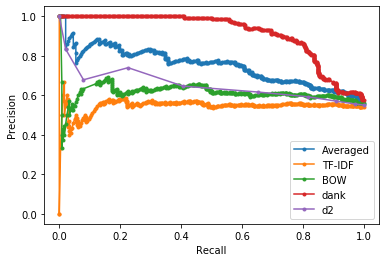

In [143]:
lr_precision, lr_recall, _ = precision_recall_curve(test_out, averaged_preds)
idf_prec, idf_rec, _ = precision_recall_curve(test_out, predictions[:,1])
bow_prec, bow_rec, _ = precision_recall_curve(test_out, count_predictions[:,1])
dank_prec, dank_rec, _ = precision_recall_curve(test_out, dank_predictions[:,1])
d2_prec, d2_rec, _ = precision_recall_curve(test_out, dp2[:,1])
plt.plot(lr_recall, lr_precision, marker='.', label='Averaged')
plt.plot(idf_rec, idf_prec, marker='.', label='TF-IDF')
plt.plot(bow_rec, bow_prec, marker='.', label='BOW')
plt.plot(dank_rec, dank_prec, marker='.', label='dank')
plt.plot(d2_rec, d2_prec, marker='.', label='d2')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [144]:
print("False Positives")
# fp_test_df = test_df[['after_dir', 'preprocessed_text']]
test_df['pred'] = predictions[i,1]
test_df['is_fp'] = np.where(((test_df["after_dir"] == 0) & (test_df['after_dir'] != test_df['pred'])), 1, 0)
test_df['is_fn'] = np.where(((test_df["after_dir"] == 1) & (test_df['after_dir'] != test_df['pred'])), 1, 0)
# for i in range(len(test_out)):
#     if test_out[i] == 0 and test_out[i] != np.round(predictions[i,1]):
#         print(test_out[i], np.round(predictions[i,1]), test_df.iloc[i].preprocessed_text)

False Positives


NameError: name 'i' is not defined

In [ ]:
test_df[test_df.is_fp == 1][['pred', 'after_dir','preprocessed_text']]